## MLP para classificação Multiclass em Imagens (MNIST)
O MNIST é uma especie de Hello World da classificação de imagens com imagens de digitos escritos à mão.
A API do torchvision já dispõe de uma função para fazer o download deste dataset. Vamos no entanto optar por ir buscar os CSVs do dataset em https://www.kaggle.com/oddrationale/mnist-in-csv 

Iremos utilizar uma rede neuronal convolucional para classificação do dígito em cada imagem de 28x28.

## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
    
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
#Constants

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'
#não estão a ser utilizados para já
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32

## 1. Preparar os Dados

In [4]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        #print(type(self.y_test[0]))
        #print(self.x_train.shape)
        #print(self.y_train.shape)
        #print(self.x_train)
        #print(self.y_train)
        
    # número de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
    # número de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
    # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar índices para casos de treino e de teste em formato flat (vetor)
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
    
# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instância do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits_flat()

    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [5]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:60000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([32, 784]), output: torch.Size([32])
Shape tensor batch casos test, input: torch.Size([32, 784]), output: torch.Size([32])
tensor([7, 6, 9, 3, 6, 0, 9, 1, 0, 0, 9, 4, 9, 0, 8, 3, 2, 5, 0, 1, 1, 9, 7, 6,
        3, 7, 5, 5, 4, 4, 4, 8])


torch.Size([32, 784])
torch.Size([32, 1, 28, 28])


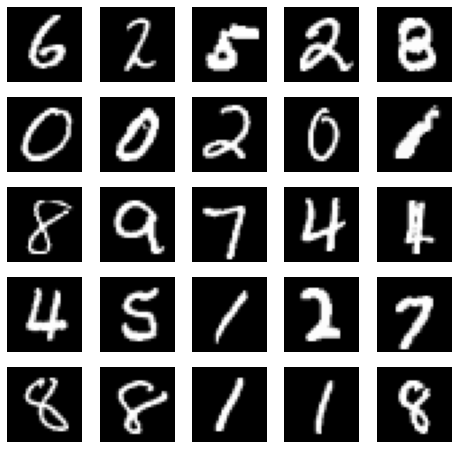

In [6]:
#Visualização das imagens

def visualize_mnist_images_flat(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()


visualize_mnist_images_flat(train_dl)

## 1.2 Verificar balanceamento do dataset

-----casos_treino------
casos: 60000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
60000


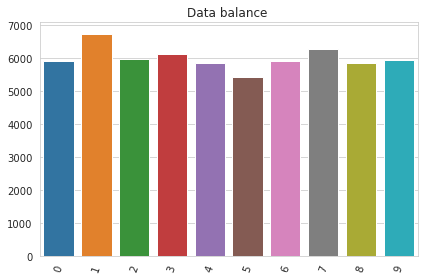

-----casos_teste------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 980 1135 1032 1010  982  892  958 1028  974 1009]
10000


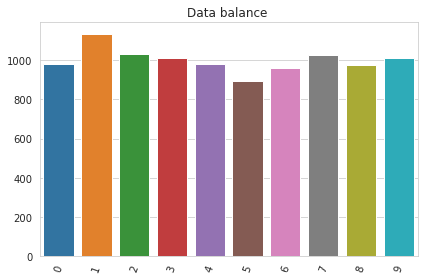

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))                            

    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x, y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show() 
    

print("-----casos_treino------")   
visualize_holdout_balance(train_dl_all)
print("-----casos_teste------") 
visualize_holdout_balance(test_dl_all)

## 2. Definir o Modelo

In [9]:
from torchinfo import summary

# Definição classe para o modelo
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 20)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu') #He initialization
        self.act1 = ReLU()
        self.hidden2 = Linear(20, 20)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(20, 10) #um nodo para cada class
        xavier_uniform_(self.hidden3.weight) #Glorot initialization
        self.act3 = Softmax(dim=1) #softmax visto ser multiclass
        
    # sequência de propagação do input 
    def forward(self, X):
        # input para a primeira camada
        X = self.hidden1(X)
        X = self.act1(X)
        # segunda camada
        #X = self.hidden2(X)
        #X = self.act2(X)
        # terceira camada e output
        X = self.hidden3(X)
        X = self.act3(X)
        return X
    
    
# definir a rede neuronal
model = MLP(784)
#visualizar a rede
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0)) #verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [32, 20]                  15,700
├─ReLU: 1-2                              [32, 20]                  --
├─Linear: 1-3                            [32, 10]                  210
├─Softmax: 1-4                           [32, 10]                  --
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.17


MLP(
  (hidden1): Linear(in_features=784, out_features=20, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=20, out_features=10, bias=True)
  (act3): Softmax(dim=1)
)

In [10]:
#alternativa de MLP muito simples, tudo com defaults
import torch.nn.functional as F 

class MLP_simples(Module):
    def __init__(self, d_in, d_out):
        super(MLP_simples, self).__init__()
        self.d_in = d_in
        self.linear1 = nn.Linear(d_in, 50)
        self.linear2 = nn.Linear(50, d_out)

    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X)
        return F.log_softmax(self.linear2(X), dim=1)
    
#model = MLP_simples(784, 10).to(device)
#print(next(model.parameters()).is_cuda)


## 3. Treinar o Modelo

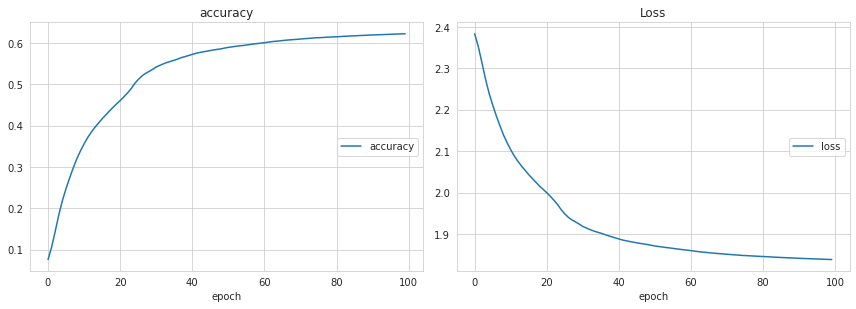

accuracy
	accuracy         	 (min:    0.076, max:    0.622, cur:    0.622)
Loss
	loss             	 (min:    1.839, max:    2.383, cur:    1.839)


In [11]:
#versão com display de gráfico
from livelossplot import PlotLosses

EPOCHS = 100
LEARNING_RATE = 0.001

# treino do modelo
def train_model(train_dl, model):
    liveloss = PlotLosses() ##para visualizarmos o processo de treino
    # definir o loss e a função de otimização
    criterion = CrossEntropyLoss() #neste caso implementa a sparse_categorical_crossentropy
    #nn.CrossEntropyLoss accepts ground truth labels directly as integers
    #in [0, N_CLASSES[ (no need to onehot encode the labels)
    #optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5) #stochastic gradient descent
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # iterar as epochs
    for epoch in range(EPOCHS):
        logs = {} ##para visualizarmos o processo de treino
        # iterar as batchs
        epoch_loss  = 0 ##para visualizarmos o processo de treino
        epoch_acc  = 0 ##para visualizarmos o processo de treino
        for i, (inputs, labels) in enumerate(train_dl): #backpropagation
            # inicializar os gradientes
            optimizer.zero_grad() #coloca os gradientes de todos os parâmetros a zero
            # calcular o output do modelo
            outputs = model(inputs)
            # calcular o loss
            loss = criterion(outputs, labels)#.unsqueeze(1))
            #acc = binary_acc(outputs, labels)#.unsqueeze(1))
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            # atribuição alteraçoes "In the backward pass we receive a Tensor containing the gradient of the loss
            #with respect to the output, and we need to compute the gradient of the loss with respect to the input.
            loss.backward()
            # update pesos do modelo
            optimizer.step()
            #só para multiclass:
            #valores, predictions = torch.max(outputs, 1) #retorna um tensor com os indices do valor maximo em cada caso
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss ##para visualizarmos o processo de treino
        logs['accuracy'] = epoch_acc/len(train_dl) ##para visualizarmos o processo de treino
        liveloss.update(logs) ##para visualizarmos o processo de treino
        liveloss.send() ##para visualizarmos o processo de treino
 
# treinar o modelo
train_model(train_dl_all, model)

## 4. Avaliar o Modelo

Accuracy: 0.324

acertou:3236 falhou:6764
              precision    recall  f1-score   support

           0       0.12      0.05      0.07       980
           1       0.59      0.76      0.66      1135
           2       0.24      0.13      0.17      1032
           3       0.38      0.76      0.51      1010
           4       0.00      0.00      0.00       982
           5       0.01      0.00      0.00       892
           6       0.34      0.55      0.42       958
           7       0.02      0.02      0.02      1028
           8       0.20      0.14      0.17       974
           9       0.30      0.74      0.42      1009

    accuracy                           0.32     10000
   macro avg       0.22      0.31      0.24     10000
weighted avg       0.23      0.32      0.25     10000

[[ 49  22  32 245   0   4 333 235  29  31]
 [  1 858   8  85   1  12  54  19  63  34]
 [ 59  97 135 379   2  30  70 133  87  40]
 [ 21  42  10 768   0   1  23  39  60  46]
 [ 87  46 137  39   0   6  

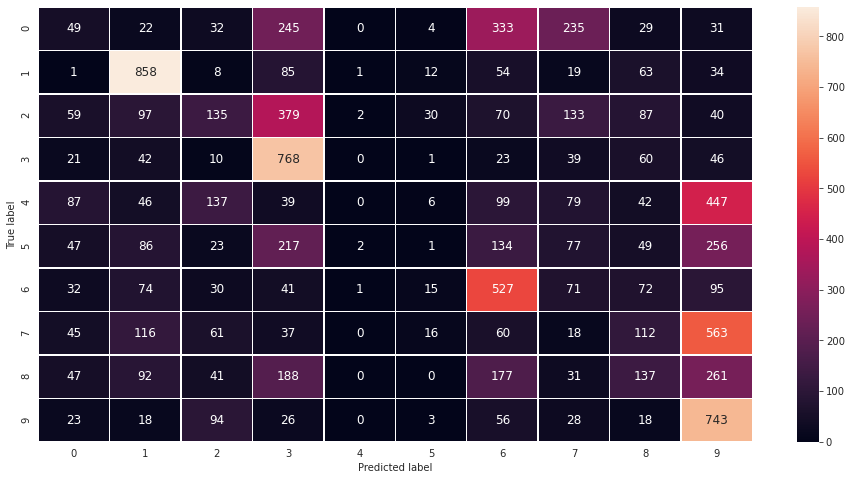

In [29]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        # avaliar o modelo com os casos de teste
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions
 
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
# avaliar o modelo
actual_values, predictions = evaluate_model(test_dl, model)
#actuals, predictions = evaluate_model(train_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    #print(f'real:{r} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1

# calcular a accuracy
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

torch.Size([32, 784])
torch.float32
predict: 9


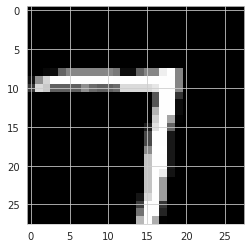

In [30]:
# fazer uma previsão utilizando um caso ...
def make_prediction(model, img_list, idx): #img shape (784,1)

    print(img_list.shape)
    print(img_list.dtype) # if t is your tensor, else you use t.type() for the other two
    #img  = torch.from_numpy(img.numpy()).float() #use for np data
    #print(img.shape)
    #print(img.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28) #shape (1,1,28,28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()

_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10) # 10 é o número do índice da imagem de input #receives an image tensor with shape (784,1)